## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.utils import resample
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (roc_curve, precision_recall_curve,accuracy_score,roc_auc_score,
                             average_precision_score,confusion_matrix,classification_report)
from scipy.stats import ttest_rel
import sys
import joblib

## Uploading and Reading Dataset

In [2]:
# Read the Excel File
df_cancer = pd.read_excel('lung_cancer.xlsx')

In [3]:
# Display the Data
df_cancer.head()

,Patient ID,Marital status at diagnosis,"Race recode (W, B, AI, API)",Sex,"Age recode (<60,60-69,70+)",YEAR,Primary Site,Histologic Type ICD-O-3,Behavior recode for analysis,Grade Recode (thru 2017),...,Rural-Urban Continuum Code,Age recode with single ages and 90+,State,Yost Index,SVI,SVI_CATEGORY,Max AQI,90th Percentile AQI,Median AQI,Unhealthy for Sensitive Groups Days
0,23860017,Widowed,American Indian/Alaska Native,Female,70-74 years,2013,341,8070,Malignant,Unknown,...,Unknown/missing/no match (Alaska or Hawaii - E...,70 years,Alaska Natives,11566.0,0.528864,medium_high,112.375000,54.375000,24.750000,4.750000
1,23860053,Unknown,American Indian/Alaska Native,Female,80-84 years,2008,341,8000,Malignant,Unknown,...,Unknown/missing/no match (Alaska or Hawaii - E...,80 years,Alaska Natives,11558.0,0.533668,medium_high,89.111111,42.222222,17.333333,3.000000
2,23860055,Unknown,American Indian/Alaska Native,Female,70-74 years,2019,341,8140,Malignant,Unknown,...,Unknown/missing/no match (Alaska or Hawaii - E...,70 years,Alaska Natives,11397.0,0.523099,medium_high,163.222222,49.555556,23.111111,3.444444
3,23860077,Widowed,American Indian/Alaska Native,Female,85+ years,2011,343,8000,Malignant,Unknown,...,Unknown/missing/no match (Alaska or Hawaii - E...,85 years,Alaska Natives,11586.0,0.530786,medium_high,101.500000,48.125000,27.250000,3.625000
4,23860079,Married (including common law),American Indian/Alaska Native,Female,75-79 years,2007,341,8010,Malignant,Poorly differentiated; Grade III,...,Unknown/missing/no match (Alaska or Hawaii - E...,78 years,Alaska Natives,11558.0,0.534629,medium_high,92.500000,44.250000,20.375000,2.125000


In [4]:
cancer = df_cancer.copy()

In [5]:
# Rename columns
cancer.rename(columns={
    'Patient ID': 'patient_id',
    'Marital status at diagnosis': 'marital_status',
    'Race recode (W, B, AI, API)': 'race_recode',
    'Sex': 'sex',
    'Age recode (<60,60-69,70+)': 'age_recode',
    'Year of diagnosis': 'year_of_diagnosis',
    'Primary Site': 'primary_site',
    'Histologic Type ICD-O-3': 'histologic_type',
    'Behavior recode for analysis': 'behavior_recode',
    'Grade Recode (thru 2017)': 'grade_recode',
    'Site specific surgery (1973-1997 varying detail by year and site)': 'site_specific_surgery',
    'Radiation recode': 'radiation_recode',
    'Combined Summary Stage (2004+)': 'summary_stage',
    'CS tumor size (2004-2015)': 'tumor_size',
    'CS extension (2004-2015)': 'cs_extension',
    'CS lymph nodes (2004-2015)': 'cs_lymph_nodes',
    'CS mets at dx (2004-2015)': 'cs_mets',
    'Regional nodes positive (1988+)': 'regional_nodes_positive',
    'Regional nodes examined (1988+)': 'regional_nodes_examined',
    'Total number of in situ/malignant tumors for patient': 'total_tumors',
    'Survival months': 'survival_months',
    'Vital status recode (study cutoff used)': 'vital_status',
    'COD to site recode ICD-O-3 2023 Revision': 'cod_recode',
    'Record number recode': 'record_number',
    'Median household income inflation adj to 2022': 'median_household_income',
    'Rural-Urban Continuum Code': 'rural_urban_code',
    'Age recode with single ages and 90+': 'age_recode_single',
    'SEER registry (with CA and GA as whole states)': 'seer_registry',
    'RX Summ--Surg Prim Site (1998+)': 'surgery_site'
}, inplace=True)


In [6]:
# Select columns
cancer = cancer[['age_recode_single',
                   'sex',   
                   'behavior_recode',
                   'cs_extension',
                   'grade_recode',
                   'histologic_type',
                   'cs_lymph_nodes',
                   'marital_status',
                   'cs_mets',
                   'primary_site',
                   'race_recode',
                   'radiation_recode',
                   'regional_nodes_positive',
                   'regional_nodes_examined',
                   'summary_stage',
                   'tumor_size',
                   'surgery_site',
                   'survival_months',
                   'vital_status',
                   'cod_recode',
                   'Yost Index',
                   'SVI',
                   'Max AQI',
                   '90th Percentile AQI',
                   'Median AQI',
                   'Unhealthy for Sensitive Groups Days'
                   ]]

In [7]:
# Summary of the DataFrame
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778194 entries, 0 to 778193
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   age_recode_single                    778194 non-null  object 
 1   sex                                  778194 non-null  object 
 2   behavior_recode                      778194 non-null  object 
 3   cs_extension                         778194 non-null  object 
 4   grade_recode                         778194 non-null  object 
 5   histologic_type                      778194 non-null  int64  
 6   cs_lymph_nodes                       778194 non-null  object 
 7   marital_status                       778194 non-null  object 
 8   cs_mets                              778194 non-null  object 
 9   primary_site                         778194 non-null  int64  
 10  race_recode                          778194 non-null  object 
 11  radiation_rec

In [8]:
# Iterate over all columns with object type (nominal features)
for column in cancer.select_dtypes(include=['object']).columns:
    unique_values = cancer[column].unique()
    print(f"Column: {column}")
    print(unique_values)
    print("\n")  # Add a newline for better readability between columns


Column: age_recode_single
['70 years' '80 years' '85 years' '78 years' '87 years' '73 years'
 '72 years' '75 years' '65 years' '81 years' '66 years' '67 years'
 '76 years' '74 years' '79 years' '84 years' '69 years' '63 years'
 '88 years' '58 years' '82 years' '61 years' '62 years' '71 years'
 '68 years' '83 years' '60 years' '51 years' '77 years' '90+ years'
 '55 years' '57 years' '47 years' '86 years' '56 years' '54 years'
 '64 years' '46 years' '49 years' '36 years' '53 years' '59 years'
 '52 years' '30 years' '50 years' '48 years' '89 years' '45 years'
 '44 years' '34 years' '40 years' '41 years' '43 years' '42 years'
 '39 years' '38 years' '37 years' '14 years' '16 years' '35 years'
 '13 years' '25 years' '28 years' '24 years' '27 years' '29 years'
 '32 years' '31 years' '21 years' '33 years' '26 years' '15 years'
 '06 years' '23 years' '18 years' '22 years' '19 years' '20 years'
 '00 years' '02 years' '10 years' '04 years' '12 years' '01 years'
 '17 years' '09 years' '03 years' '

In [9]:
# Check for missing values in each column
cancer.isna().sum()

age_recode_single                        0
sex                                      0
behavior_recode                          0
cs_extension                             0
grade_recode                             0
histologic_type                          0
cs_lymph_nodes                           0
marital_status                           0
cs_mets                                  0
primary_site                             0
race_recode                              0
radiation_recode                         0
regional_nodes_positive                  0
regional_nodes_examined                  0
summary_stage                            0
tumor_size                               0
surgery_site                             0
survival_months                          0
vital_status                             0
cod_recode                               0
Yost Index                              73
SVI                                      0
Max AQI                                513
90th Percen

## Data Cleaning

In [10]:
# Column: age_recode_single

print(cancer['age_recode_single'].unique())

# Create a copy of the original column to avoid modifying it directly
cancer['age'] = cancer['age_recode_single'].replace('90+ years', '90')

# Remove the ' years' part and convert the result to numeric
cancer['age'] = cancer['age'].str.replace(' years', '').astype(int)

# Delete a column
cancer.drop('age_recode_single', axis=1, inplace=True)

# Now 'Age_numeric' contains the cleaned age values
print(cancer['age'].head())

['70 years' '80 years' '85 years' '78 years' '87 years' '73 years'
 '72 years' '75 years' '65 years' '81 years' '66 years' '67 years'
 '76 years' '74 years' '79 years' '84 years' '69 years' '63 years'
 '88 years' '58 years' '82 years' '61 years' '62 years' '71 years'
 '68 years' '83 years' '60 years' '51 years' '77 years' '90+ years'
 '55 years' '57 years' '47 years' '86 years' '56 years' '54 years'
 '64 years' '46 years' '49 years' '36 years' '53 years' '59 years'
 '52 years' '30 years' '50 years' '48 years' '89 years' '45 years'
 '44 years' '34 years' '40 years' '41 years' '43 years' '42 years'
 '39 years' '38 years' '37 years' '14 years' '16 years' '35 years'
 '13 years' '25 years' '28 years' '24 years' '27 years' '29 years'
 '32 years' '31 years' '21 years' '33 years' '26 years' '15 years'
 '06 years' '23 years' '18 years' '22 years' '19 years' '20 years'
 '00 years' '02 years' '10 years' '04 years' '12 years' '01 years'
 '17 years' '09 years' '03 years' '11 years' '07 years' '05 y

In [11]:
# Column:sex

# Define a mapping dictionary for sex
sex_mapping = {
    'Male': 1,
    'Female': 2,
}

# Apply the mapping to the 'marital_status' column
cancer['sex_encoded'] = cancer['sex'].map(sex_mapping)

cancer = cancer.drop(columns=['sex'])

In [12]:
# Column: behavior_recode

# Delete a column
cancer.drop('behavior_recode', axis=1, inplace=True)

In [13]:
# Column: cs_extension

# Convert numeric values to integers
cancer['cs_extension'] = pd.to_numeric(cancer['cs_extension'], errors='coerce')

# count the number of NaN values
unknown_count = cancer['cs_extension'].isna().sum()

print(f"Number of 'cs_extension ' that are 'Blank(s)': {unknown_count}")

Number of 'cs_extension ' that are 'Blank(s)': 199352


In [14]:
# Column: grade_recode

# Define the severity mapping
severity_mapping = {
    'Well differentiated; Grade I': 1,
    'Moderately differentiated; Grade II': 2,
    'Poorly differentiated; Grade III': 3,
    'Undifferentiated; anaplastic; Grade IV': 4,
    'Unknown': 5
}
# Apply the mapping to the DataFrame
cancer['grade_level'] = cancer['grade_recode'].map(severity_mapping)

# Delete a column
cancer.drop('grade_recode', axis=1, inplace=True)

# Count the number of NaN values
print(cancer['grade_level'].isna().sum())

0


In [15]:
# Column: cs_lymph_nodes

# Convert numeric values to integers
cancer['cs_lymph_nodes'] = pd.to_numeric(cancer['cs_lymph_nodes'], errors='coerce')

# count the number of NaN values
unknown_count = cancer['cs_lymph_nodes'].isna().sum()

print(f"Number of 'cs_lymph_nodes' that are 'Blank(s)': {unknown_count}")

Number of 'cs_lymph_nodes' that are 'Blank(s)': 199352


In [16]:
# Column: marital_status

# Define a mapping dictionary for marital_status
marital_status_mapping = {
    'Married (including common law)': 1,
    'Widowed': 4,
    'Single (never married)':2,
    'Divorced':3,
    'Unmarried or Domestic Partner':6,
    'Separated':5,
    'Unknown': 7,
}

# Apply the mapping to the 'marital_status' column
cancer['marital_status_encoded'] = cancer['marital_status'].map(marital_status_mapping)

cancer = cancer.drop(columns=['marital_status'])

unknown_count = cancer['marital_status_encoded'].isna().sum()

print(f"Number of 'marital_status_encoded' that are 'Blank(s)': {unknown_count}")

Number of 'marital_status_encoded' that are 'Blank(s)': 0


In [17]:
# Column: cs_mets

# Convert numeric values to integers
cancer['cs_mets'] = pd.to_numeric(cancer['cs_mets'], errors='coerce')

# count the number of NaN values
unknown_count = cancer['cs_mets'].isna().sum()

print(f"Number of 'cs_mets' that are 'Blank(s)': {unknown_count}")


Number of 'cs_mets' that are 'Blank(s)': 199352


In [18]:
# Column:race_recode

# Define a mapping dictionary for race_recode
race_recode_mapping = {
    'White': 4,
    'Asian or Pacific Islander': 2,
    'Black':5,
    'Unknown': 3,
    'American Indian/Alaska Native': 1
}

# Apply the mapping to the 'race_recode' column
cancer['race_recode_encoded'] = cancer['race_recode'].map(race_recode_mapping)

cancer = cancer.drop(columns=['race_recode'])

# count the number of NaN values
unknown_count = cancer['race_recode_encoded'].isna().sum()

print(f"Number of 'race_recode_encoded' that are 'Blank(s)': {unknown_count}")

Number of 'race_recode_encoded' that are 'Blank(s)': 0


In [19]:
# Column:radiation_recode

# Define a mapping dictionary for radiation_recode
radiation_recode_mapping = {'Beam radiation': 1,  'Combination of beam with implants or isotopes': 2, 'None/Unknown': 3,
                   'Radiation, NOS  method or source not specified': 4,
                   'Radioactive implants (includes brachytherapy) (1988+)': 5, 'Radioisotopes (1988+)': 6, 'Recommended, unknown if administered': 7,
           'Refused (1988+)': 8}

# Apply the mapping to the 'radiation_recode' column
cancer['radiation_recode_encoded'] = cancer['radiation_recode'].map(radiation_recode_mapping)

cancer = cancer.drop(columns=['radiation_recode'])

# count the number of NaN values
unknown_count = cancer['radiation_recode_encoded'].isna().sum()

print(f"Number of 'radiation_recode_encoded' that are 'Blank(s)': {unknown_count}")


Number of 'radiation_recode_encoded' that are 'Blank(s)': 0


In [20]:
# Column: tumor_size

#Convert numeric values to integers
cancer['tumor_size'] = pd.to_numeric(cancer['tumor_size'], errors='coerce')

In [21]:
# Column: survival_months

# Convert numeric values to integers
cancer['survival_months'] = pd.to_numeric(cancer['survival_months'], errors='coerce')

# count the number of NaN values
unknown_count = cancer['survival_months'].isna().sum()

print(f"Number of 'survival_months' that are 'Unknown': {unknown_count}")

Number of 'survival_months' that are 'Unknown': 17245


In [22]:
# Column: vital_status

# Define a mapping dictionary for vital_status
vital_status_mapping = {
    'Dead': 0,
    'Alive': 1
}

# Apply the mapping to the 'vital_status' column
cancer['vital_status_encoded'] = cancer['vital_status'].map(vital_status_mapping)
cancer = cancer.drop(columns=['vital_status'])


In [23]:
# Check for missing values in each column
cancer.isna().sum()

cs_extension                           199352
histologic_type                             0
cs_lymph_nodes                         199352
cs_mets                                199352
primary_site                                0
regional_nodes_positive                     0
regional_nodes_examined                     0
summary_stage                               0
tumor_size                             199352
surgery_site                                0
survival_months                         17245
cod_recode                                  0
Yost Index                                 73
SVI                                         0
Max AQI                                   513
90th Percentile AQI                       513
Median AQI                                513
Unhealthy for Sensitive Groups Days       513
age                                         0
sex_encoded                                 0
grade_level                                 0
marital_status_encoded            

In [24]:
# Show summary info: columns, data types, non-null counts, and memory usage
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778194 entries, 0 to 778193
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   cs_extension                         578842 non-null  float64
 1   histologic_type                      778194 non-null  int64  
 2   cs_lymph_nodes                       578842 non-null  float64
 3   cs_mets                              578842 non-null  float64
 4   primary_site                         778194 non-null  int64  
 5   regional_nodes_positive              778194 non-null  int64  
 6   regional_nodes_examined              778194 non-null  int64  
 7   summary_stage                        778194 non-null  object 
 8   tumor_size                           578842 non-null  float64
 9   surgery_site                         778194 non-null  int64  
 10  survival_months                      760949 non-null  float64
 11  cod_recode   

## Creating Target Variable (Survivability)

In [25]:
# Drop rows with missing values
cancer = cancer.dropna(subset=['survival_months','cs_extension','cs_lymph_nodes','cs_mets','tumor_size', 'Max AQI','90th Percentile AQI','Median AQI','Yost Index',
'Unhealthy for Sensitive Groups Days'])


In [26]:
# Define the function to determine survivability and map to 1 or 0
def determine_survivability(row):
    if row['survival_months'] >= 60 and row['vital_status_encoded'] == 1:
        return 1  # survived
    elif row['survival_months'] < 60 and row['cod_recode'] == 'Lung And Bronchus':
        return 0  # not survived
    else:
        return -1  # exclusion

# Apply the function to the DataFrame
cancer['survivability'] = cancer.apply(determine_survivability, axis=1)

# Get the counts of each category in the 'survivability' column
cancer['survivability'].value_counts()

 0    375189
-1    143479
 1     47454
Name: survivability, dtype: int64

In [27]:
# Remove rows where 'survivability' is 'excluded'
cancer = cancer[cancer['survivability'] != -1].copy()

In [28]:
# Check for missing values in each column
cancer.isnull().sum()

cs_extension                           0
histologic_type                        0
cs_lymph_nodes                         0
cs_mets                                0
primary_site                           0
regional_nodes_positive                0
regional_nodes_examined                0
summary_stage                          0
tumor_size                             0
surgery_site                           0
survival_months                        0
cod_recode                             0
Yost Index                             0
SVI                                    0
Max AQI                                0
90th Percentile AQI                    0
Median AQI                             0
Unhealthy for Sensitive Groups Days    0
age                                    0
sex_encoded                            0
grade_level                            0
marital_status_encoded                 0
race_recode_encoded                    0
radiation_recode_encoded               0
vital_status_enc

## Categorizing Dataset Base on 'summary_stage' Feature

In [29]:
def visualize_column(df, column_name):
    # Get the data for the column
    data = df[column_name]

    # Determine the type of data
    if data.dtype == 'object':  
        plt.figure(figsize=(10, 6))
        sns.countplot(y=data, order=data.value_counts().index)
        plt.title(f'Count of {column_name}')
        plt.xlabel('Count')
        plt.ylabel(column_name)
        plt.show()

    elif pd.api.types.is_numeric_dtype(data):  
        plt.figure(figsize=(10, 6))
        sns.histplot(data, bins=30, kde=True)
        plt.title(f'Distribution of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.show()

    elif pd.api.types.is_datetime64_any_dtype(data): 
        plt.figure(figsize=(10, 6))
        data = data.dt.to_period('M')  
        sns.countplot(x=data)
        plt.title(f'Time Series of {column_name}')
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

    else:
        print(f"Data type of column {column_name} is not supported for visualization.")

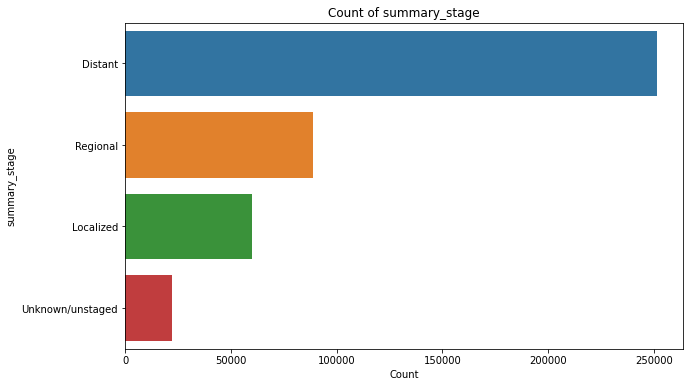

In [30]:
visualize_column(cancer, 'summary_stage' )

In [31]:
# Check unique values in 'summary_stage'
unique_values = cancer['summary_stage'].unique()
print("Unique values in 'summary_stage':", unique_values)

# Create subsets based on each unique value
subsets = {}
for value in unique_values:
    subsets[value] = cancer[cancer['summary_stage'] == value]

Unique values in 'summary_stage': ['Regional' 'Unknown/unstaged' 'Distant' 'Localized']


In [32]:
# Example: Accessing a specific subset
subset_regional = subsets['Regional']
subset_localized = subsets['Localized']
subset_distant = subsets['Distant']

## Assessing Class Distribution Before Model Training

0    74023
1    14992
Name: survivability, dtype: int64
0    83.157895
1    16.842105
Name: survivability, dtype: float64


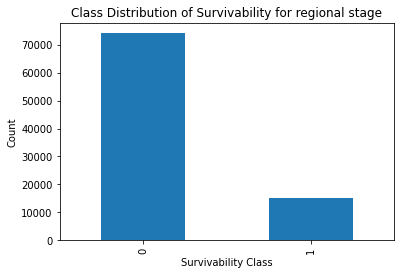

In [33]:
# Count the number of instances for each class in the 'survivability' column
class_counts = subset_regional['survivability'].value_counts()

# Display the class distribution
print(class_counts)

# Calculate the percentage distribution as well
class_percentage = subset_regional['survivability'].value_counts(normalize=True) * 100
print(class_percentage)


# Bar plot to visualize class distribution
class_counts.plot(kind='bar')
plt.title("Class Distribution of Survivability for regional stage")
plt.xlabel("Survivability Class")
plt.ylabel("Count")
plt.show()


0    34085
1    25979
Name: survivability, dtype: int64
0    56.747802
1    43.252198
Name: survivability, dtype: float64


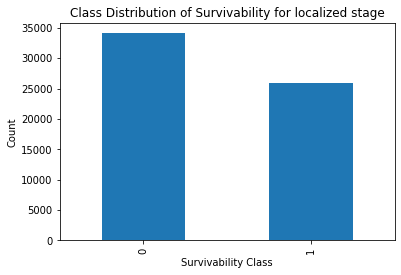

In [34]:
# Count the number of instances for each class in the 'survivability' column
class_counts = subset_localized['survivability'].value_counts()

# Display the class distribution
print(class_counts)

# calculate the percentage distribution as well
class_percentage = subset_localized['survivability'].value_counts(normalize=True) * 100
print(class_percentage)

# Bar plot to visualize class distribution
class_counts.plot(kind='bar')
plt.title("Class Distribution of Survivability for localized stage")
plt.xlabel("Survivability Class")
plt.ylabel("Count")
plt.show()


0    245789
1      5592
Name: survivability, dtype: int64
0    97.775488
1     2.224512
Name: survivability, dtype: float64


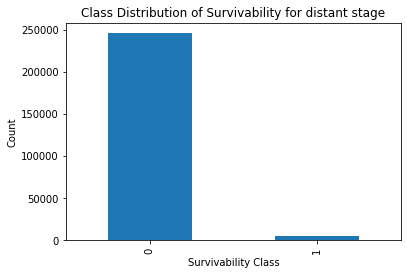

In [35]:
# Count the number of instances for each class in the 'survivability' column
class_counts = subset_distant['survivability'].value_counts()

# Display the class distribution
print(class_counts)

# Calculate the percentage distribution as well
class_percentage = subset_distant['survivability'].value_counts(normalize=True) * 100
print(class_percentage)

# Bar plot to visualize class distribution
class_counts.plot(kind='bar')
plt.title("Class Distribution of Survivability for distant stage")
plt.xlabel("Survivability Class")
plt.ylabel("Count")
plt.show()

## Undersampling

### Localized

In [36]:
majority_class = subset_localized[subset_localized['survivability'] == 0]
minority_class = subset_localized[subset_localized['survivability'] == 1]

if len(majority_class) > len(minority_class):
    majority_undersampled = resample(
        majority_class,
        replace=False,
        n_samples=len(minority_class),
        random_state=42
    )
    undersampled_localized = pd.concat([majority_undersampled, minority_class])
elif len(minority_class) > len(majority_class):
    minority_oversampled = resample(
        minority_class,
        replace=False,
        n_samples=len(majority_class),
        random_state=42
    )
    undersampled_localized = pd.concat([majority_class, minority_oversampled])
else:
    undersampled_localized = pd.concat([majority_class, minority_class])

undersampled_localized = undersampled_localized.sample(frac=1, random_state=42).reset_index(drop=True)

print("Localized survivability distribution:")
print(undersampled_localized['survivability'].value_counts())

Localized survivability distribution:
1    25979
0    25979
Name: survivability, dtype: int64


### Regional

In [37]:
majority_class = subset_regional[subset_regional['survivability'] == 0]
minority_class = subset_regional[subset_regional['survivability'] == 1]

if len(majority_class) > len(minority_class):
    majority_undersampled = resample(
        majority_class,
        replace=False,
        n_samples=len(minority_class),
        random_state=42
    )
    undersampled_regional = pd.concat([majority_undersampled, minority_class])
elif len(minority_class) > len(majority_class):
    minority_oversampled = resample(
        minority_class,
        replace=False,
        n_samples=len(majority_class),
        random_state=42
    )
    undersampled_regional = pd.concat([majority_class, minority_oversampled])
else:
    undersampled_regional = pd.concat([majority_class, minority_class])

undersampled_regional = undersampled_regional.sample(frac=1, random_state=42).reset_index(drop=True)

print("Regional survivability distribution:")
print(undersampled_regional['survivability'].value_counts())


Regional survivability distribution:
0    14992
1    14992
Name: survivability, dtype: int64


### Distant

In [38]:
majority_class = subset_distant[subset_distant['survivability'] == 0]
minority_class = subset_distant[subset_distant['survivability'] == 1]

if len(majority_class) > len(minority_class):
    majority_undersampled = resample(
        majority_class,
        replace=False,
        n_samples=len(minority_class),
        random_state=42
    )
    undersampled_distant = pd.concat([majority_undersampled, minority_class])
elif len(minority_class) > len(majority_class):
    minority_oversampled = resample(
        minority_class,
        replace=False,
        n_samples=len(majority_class),
        random_state=42
    )
    undersampled_distant = pd.concat([majority_class, minority_oversampled])
else:
    undersampled_distant = pd.concat([majority_class, minority_class])

undersampled_distant = undersampled_distant.sample(frac=1, random_state=42).reset_index(drop=True)

print("Distant survivability distribution:")
print(undersampled_distant['survivability'].value_counts())

Distant survivability distribution:
1    5592
0    5592
Name: survivability, dtype: int64


## XGBoost Model — Building, Training and Calculating EOD

### Regional Stage

In [70]:
# Separate array into input and output components
X_regional = undersampled_regional.drop(['survivability', 'vital_status_encoded', 'survival_months','summary_stage','cod_recode'], axis=1)
y_regional = undersampled_regional['survivability']

In [71]:
# Define XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              max_depth=3,   # reduce depth to avoid overfitting
                              learning_rate=0.1,
                              n_estimators=50,
                              random_state=42,
                              reg_alpha=0.1,  # L1 regularization
                              reg_lambda=0.1  # L2 regularization
                             )

# Set up 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use cross_val_predict to get predictions for each fold
y_pred = cross_val_predict(xgb_model, X_regional, y_regional, cv=kf)

# Generate classification report and other metrics for overall predictions
print("Classification Report:")
print(classification_report(y_regional, y_pred))


# Confusion matrix
conf_matrix = confusion_matrix(y_regional, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")


# Calculate and print accuracy
accuracy = accuracy_score(y_regional, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")


# ROC AUC score
y_pred_proba = cross_val_predict(xgb_model, X_regional, y_regional, cv=kf, method='predict_proba')[:, 1]
auc_score = roc_auc_score(y_regional, y_pred_proba)
print(f'Area Under ROC Curve (AUC): {auc_score:.4f}')

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     14992
           1       0.79      0.80      0.79     14992

    accuracy                           0.79     29984
   macro avg       0.79      0.79      0.79     29984
weighted avg       0.79      0.79      0.79     29984

Confusion Matrix:
[[11868  3124]
 [ 3056 11936]]
Overall Accuracy: 0.7939
Area Under ROC Curve (AUC): 0.8762


In [ ]:
# Train the final XGBoost model on all data
xgb_model.fit(X_regional, y_regional)
# Save the model to a file
joblib.dump(xgb_model, "fair_xgb_regional_stage.pkl")
print("Model saved as fair_xgb_regional_stage.pkl")

Model saved as fair_xgb_regional_stage.pkl


#### Binning & Equalized Odds

In [41]:
# Define bins and labels based on quartiles
bins = [0, 0.25, 0.50, 0.75, 1]
labels = ['Low', 'Low-Medium', 'Medium-High', 'High']

# Apply categorization 
X_regional['SVI_Category'] = pd.cut(X_regional['SVI'], bins=bins, labels=labels, include_lowest=True)

In [42]:
# Define the bins and labels based on the AQI table from the image
aqi_bins = [0, 50, 100, 150, 200, 300, float('inf')]
aqi_labels = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

# Apply categorization
X_regional['Median_AQI_Category'] = pd.cut(X_regional['Median AQI'], bins=aqi_bins, labels=aqi_labels, include_lowest=True)
# X_regional['Percentile_90_AQI_Category'] = pd.cut(X_regional['90th Percentile AQI'], bins=aqi_bins, labels=aqi_labels, include_lowest=True)
# X_regional['Max_AQI_Category'] = pd.cut(X_regional['Max AQI'], bins=aqi_bins, labels=aqi_labels, include_lowest=True)

In [43]:
def assign_yost_quintile(yost_index):
    """Assigns a Yost Quintile based on the given Yost Index value."""
    if 8114.0 <= yost_index < 9011.0:
        return 'Very Low SES'
    elif 9011.0 <= yost_index < 9682.0:
        return 'Low SES'
    elif 9682.0 <= yost_index < 10325.0:
        return 'Medium SES'
    elif 10325.0 <= yost_index < 10989.0:
        return 'High SES'
    elif 10989.0 <= yost_index < 11870.0:
        return 'Very High SES'
    else:
        return None  # Return None if the value is outside the expected range
    
# Apply the function to create the new 'Yost Quintile' column in the Cancer DataFrame
X_regional["Yost Quintile Categoty"] = X_regional["Yost Index"].apply(assign_yost_quintile)   

In [44]:
# Define the sensitive features
sensitive_features = ['Yost Quintile Categoty','SVI_Category','Median_AQI_Category']
sensitive_data = X_regional[sensitive_features]  # Subset of sensitive columns

In [45]:
# Function to calculate Equalized Odds
def calculate_equalized_odds(y_true, y_pred, sensitive_data, sensitive_column):
    """
    Calculate Equalized Odds metrics: TPR and FPR for each group in the sensitive feature.
    """
    sensitive_groups = sensitive_data[sensitive_column].unique()  # Unique groups in the sensitive feature

    tpr_fpr_dict = {}  # Dictionary to store TPR and FPR for each group

    for group in sensitive_groups:
        group_mask = sensitive_data[sensitive_column] == group

        # True Positives, False Positives, False Negatives, True Negatives
        tp = np.sum((y_pred[group_mask] == 1) & (y_true[group_mask] == 1))
        fp = np.sum((y_pred[group_mask] == 1) & (y_true[group_mask] == 0))
        fn = np.sum((y_pred[group_mask] == 0) & (y_true[group_mask] == 1))
        tn = np.sum((y_pred[group_mask] == 0) & (y_true[group_mask] == 0))

        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_fpr_dict[group] = {'TPR': tpr, 'FPR': fpr}

    return tpr_fpr_dict

In [46]:
# Loop through each sensitive feature to calculate Equalized Odds
for sensitive_column in sensitive_features:
    print(f"\n======== Evaluating Metrics for Sensitive Feature: {sensitive_column} =======")

    equalized_odds = calculate_equalized_odds(y_regional, y_pred, sensitive_data, sensitive_column)

    for group, metrics in equalized_odds.items():
        print(f"Group {group}: TPR = {metrics['TPR']:.4f}, FPR = {metrics['FPR']:.4f}")


======== Evaluating Metrics for Sensitive Feature: Yost Quintile Categoty =======
Group Very High SES: TPR = 0.8174, FPR = 0.2216
Group High SES: TPR = 0.7704, FPR = 0.2024
Group Low SES: TPR = 0.7503, FPR = 0.1929
Group Medium SES: TPR = 0.7709, FPR = 0.1905
Group Very Low SES: TPR = 0.7599, FPR = 0.1828

======== Evaluating Metrics for Sensitive Feature: SVI_Category =======
Group Medium-High: TPR = 0.7942, FPR = 0.2046
Group High: TPR = 0.7930, FPR = 0.2330
Group Low-Medium: TPR = 0.8649, FPR = 0.3274

======== Evaluating Metrics for Sensitive Feature: Median_AQI_Category =======
Group Moderate: TPR = 0.7930, FPR = 0.2016
Group Good: TPR = 0.7978, FPR = 0.2118


In [47]:
def equalized_odds_distance(tpr1, fpr1, tpr2, fpr2):
    """
    Computes the equalized odds distance between two groups.
    """
    tpr_diff = abs(tpr1 - tpr2)
    fpr_diff = abs(fpr1 - fpr2)
    distance = tpr_diff + fpr_diff
    return distance

In [48]:
metrics = {
    "Yost_Quintile_Category": {
        "Very High SES": {"TPR": 0.8174, "FPR": 0.2216},
        "Very Low SES":  {"TPR": 0.7599, "FPR": 0.1828},
    },
    "SVI_Category": {
        "High":        {"TPR": 0.7930, "FPR": 0.2330},
        "Low-Medium":  {"TPR": 0.8649, "FPR": 0.3274},
    },
    "Median_AQI_Category": {
        "Moderate": {"TPR": 0.7930, "FPR": 0.2016},
        "Good":     {"TPR": 0.7978, "FPR": 0.2118},
    },
}


In [ ]:
# Use the function for each feature 
for feature, groups in metrics.items():
    group_names = list(groups.keys())
    g1, g2 = group_names[0], group_names[1]  # since each has 2 groups
    vals1, vals2 = groups[g1], groups[g2]

    result = equalized_odds_distance(
        vals1["TPR"], vals1["FPR"], vals2["TPR"], vals2["FPR"]
    )

    print(f"\nFeature: {feature}")
    print(f"{g1} → TPR={vals1['TPR']}, FPR={vals1['FPR']}")
    print(f"{g2} → TPR={vals2['TPR']}, FPR={vals2['FPR']}")
    print(f"Equalized Odds Distance: {result:.4f}")


Feature: Yost_Quintile_Category
Very High SES → TPR=0.8174, FPR=0.2216
Very Low SES → TPR=0.7599, FPR=0.1828
Equalized Odds Distance: 0.0963

Feature: SVI_Category
High → TPR=0.793, FPR=0.233
Low-Medium → TPR=0.8649, FPR=0.3274
Equalized Odds Distance: 0.1663

Feature: Median_AQI_Category
Moderate → TPR=0.793, FPR=0.2016
Good → TPR=0.7978, FPR=0.2118
Equalized Odds Distance: 0.0150


### Localized Stage

In [75]:
# Separate array into input and output components
X_localized = undersampled_localized.drop(['survivability', 'vital_status_encoded', 'survival_months','summary_stage','cod_recode'], axis=1)
y_localized = undersampled_localized['survivability']

In [76]:
# Define XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              max_depth=3,   # reduce depth to avoid overfitting
                              learning_rate=0.1,
                              n_estimators=50,
                              random_state=42,
                              reg_alpha=0.1,  # L1 regularization
                              reg_lambda=0.1  # L2 regularization
                             )

# Set up 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use cross_val_predict to get predictions for each fold
y_pred = cross_val_predict(xgb_model, X_localized, y_localized, cv=kf)

# Generate classification report and other metrics for overall predictions
print("Classification Report:")
print(classification_report(y_localized, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_localized, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Calculate and print accuracy
accuracy = accuracy_score(y_localized, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

# ROC AUC score
y_pred_proba = cross_val_predict(xgb_model, X_localized, y_localized, cv=kf, method='predict_proba')[:, 1]
auc_score = roc_auc_score(y_localized, y_pred_proba)
print(f'Area Under ROC Curve (AUC): {auc_score:.4f}')


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81     25979
           1       0.80      0.85      0.82     25979

    accuracy                           0.82     51958
   macro avg       0.82      0.82      0.82     51958
weighted avg       0.82      0.82      0.82     51958

Confusion Matrix:
[[20444  5535]
 [ 3919 22060]]
Overall Accuracy: 0.8180
Area Under ROC Curve (AUC): 0.8986


In [77]:
# Train the final XGBoost model on all data
xgb_model.fit(X_localized, y_localized)
# Save the model to a file
joblib.dump(xgb_model, "fair_xgb_localized_stage.pkl")
print("Model saved as fair_xgb_localized_stage.pkl")

Model saved as fair_xgb_localized_stage.pkl


#### Binning & Equalized Odds

In [52]:
# Define bins and labels based on quartiles
bins = [0, 0.25, 0.50, 0.75, 1]
labels = ['Low', 'Low-Medium', 'Medium-High', 'High']

# Apply categorization 
X_localized['SVI_Category'] = pd.cut(X_localized['SVI'], bins=bins, labels=labels, include_lowest=True)

In [53]:
# Define the bins and labels based on the AQI table from the image
aqi_bins = [0, 50, 100, 150, 200, 300, float('inf')]
aqi_labels = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

# Apply categorization
X_localized['Median_AQI_Category'] = pd.cut(X_localized['Median AQI'], bins=aqi_bins, labels=aqi_labels, include_lowest=True)
# X_localized['Percentile_90_AQI_Category'] = pd.cut(X_localized['90th Percentile AQI'], bins=aqi_bins, labels=aqi_labels, include_lowest=True)
# X_localized['Max_AQI_Category'] = pd.cut(X_localized['Max AQI'], bins=aqi_bins, labels=aqi_labels, include_lowest=True)

In [54]:
def assign_yost_quintile(yost_index):
    """Assigns a Yost Quintile based on the given Yost Index value."""
    if 8114.0 <= yost_index < 9011.0:
        return 'Very Low SES'
    elif 9011.0 <= yost_index < 9682.0:
        return 'Low SES'
    elif 9682.0 <= yost_index < 10325.0:
        return 'Medium SES'
    elif 10325.0 <= yost_index < 10989.0:
        return 'High SES'
    elif 10989.0 <= yost_index < 11870.0:
        return 'Very High SES'
    else:
        return None  # Return None if the value is outside the expected range
    
# Apply the function to create the new 'Yost Quintile' column in the Cancer DataFrame
X_localized["Yost Quintile Categoty"] = X_localized["Yost Index"].apply(assign_yost_quintile)   

In [55]:
# Define the sensitive features
sensitive_features = ['Yost Quintile Categoty','SVI_Category','Median_AQI_Category']
sensitive_data = X_localized[sensitive_features]  # Subset of sensitive columns

In [56]:
# Loop through each sensitive feature to calculate Equalized Odds
for sensitive_column in sensitive_features:
    print(f"\n======== Evaluating Metrics for Sensitive Feature: {sensitive_column} =======")

    equalized_odds = calculate_equalized_odds(y_localized, y_pred, sensitive_data, sensitive_column)

    for group, metrics in equalized_odds.items():
        print(f"Group {group}: TPR = {metrics['TPR']:.4f}, FPR = {metrics['FPR']:.4f}")


======== Evaluating Metrics for Sensitive Feature: Yost Quintile Categoty =======
Group Very High SES: TPR = 0.8692, FPR = 0.2345
Group High SES: TPR = 0.8364, FPR = 0.2066
Group Medium SES: TPR = 0.8069, FPR = 0.1645
Group Very Low SES: TPR = 0.7948, FPR = 0.1947
Group Low SES: TPR = 0.7783, FPR = 0.1980

======== Evaluating Metrics for Sensitive Feature: SVI_Category =======
Group Medium-High: TPR = 0.8502, FPR = 0.2104
Group Low-Medium: TPR = 0.8785, FPR = 0.2845
Group High: TPR = 0.8263, FPR = 0.2291

======== Evaluating Metrics for Sensitive Feature: Median_AQI_Category =======
Group Good: TPR = 0.8534, FPR = 0.2161
Group Moderate: TPR = 0.8416, FPR = 0.2074


In [57]:
metrics = {
    "Yost_Quintile_Category": {
        "Very High SES": {"TPR": 0.8692, "FPR": 0.2345},
        "Very Low SES":  {"TPR": 0.7948, "FPR": 0.1947},
    },
    "SVI_Category": {
        "Low-Medium":  {"TPR": 0.8785, "FPR": 0.2845},
        "High":        {"TPR": 0.8263, "FPR": 0.2291},
    },
    "Median_AQI_Category": {
        "Good":     {"TPR": 0.8534, "FPR": 0.2161},
        "Moderate": {"TPR": 0.8416, "FPR": 0.2074},
    },
}


In [ ]:
# Use the function for each feature 
for feature, groups in metrics.items():
    group_names = list(groups.keys())
    g1, g2 = group_names[0], group_names[1]  # since each has 2 groups
    vals1, vals2 = groups[g1], groups[g2]

    result = equalized_odds_distance(
        vals1["TPR"], vals1["FPR"], vals2["TPR"], vals2["FPR"]
    )

    print(f"\nFeature: {feature}")
    print(f"{g1} → TPR={vals1['TPR']}, FPR={vals1['FPR']}")
    print(f"{g2} → TPR={vals2['TPR']}, FPR={vals2['FPR']}")
    print(f"Equalized Odds Distance: {result:.4f}")


Feature: Yost_Quintile_Category
Very High SES → TPR=0.8692, FPR=0.2345
Very Low SES → TPR=0.7948, FPR=0.1947
Equalized Odds Distance: 0.1142

Feature: SVI_Category
Low-Medium → TPR=0.8785, FPR=0.2845
High → TPR=0.8263, FPR=0.2291
Equalized Odds Distance: 0.1076

Feature: Median_AQI_Category
Good → TPR=0.8534, FPR=0.2161
Moderate → TPR=0.8416, FPR=0.2074
Equalized Odds Distance: 0.0205


### Distant Stage

In [78]:
# Separate array into input and output components
X_distant = undersampled_distant.drop(['survivability', 'vital_status_encoded', 'survival_months','summary_stage','cod_recode'], axis=1)
y_distant = undersampled_distant['survivability']

In [79]:
# Define XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              max_depth=3,   # reduce depth to avoid overfitting
                              learning_rate=0.1,
                              n_estimators=50,
                              random_state=42,
                              reg_alpha=0.1,  # L1 regularization
                              reg_lambda=0.1  # L2 regularization
                             )

# Step 1: Set up 5-fold cross-validation without train-test split
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 2: Use cross_val_predict to get predictions for each fold
y_pred = cross_val_predict(xgb_model, X_distant, y_distant, cv=kf)

# Step 3: Generate classification report and other metrics for overall predictions
print("Classification Report:")
print(classification_report(y_distant, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_distant, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")


# Confusion matrix
conf_matrix = confusion_matrix(y_distant, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# ROC AUC score
y_pred_proba = cross_val_predict(xgb_model, X_distant, y_distant, cv=kf, method='predict_proba')[:, 1]
auc_score = roc_auc_score(y_distant, y_pred_proba)
print(f'Area Under ROC Curve (AUC): {auc_score:.4f}')


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      5592
           1       0.79      0.77      0.78      5592

    accuracy                           0.78     11184
   macro avg       0.78      0.78      0.78     11184
weighted avg       0.78      0.78      0.78     11184

Overall Accuracy: 0.7844
Confusion Matrix:
[[4452 1140]
 [1271 4321]]
Area Under ROC Curve (AUC): 0.8653


In [80]:
# Train the final XGBoost model on all data
xgb_model.fit(X_distant, y_distant)
# Save the model to a file
joblib.dump(xgb_model, "fair_xgb_distant_stage.pkl")
print("Model saved as fair_xgb_distant_stage.pkl")

Model saved as fair_xgb_distant_stage.pkl


#### Binning & Equalized Odds

In [61]:
# Define bins and labels based on quartiles
bins = [0, 0.25, 0.50, 0.75, 1]
labels = ['Low', 'Low-Medium', 'Medium-High', 'High']

# Apply categorization 
X_distant['SVI_Category'] = pd.cut(X_distant['SVI'], bins=bins, labels=labels, include_lowest=True)

In [62]:
# Define the bins and labels based on the AQI table from the image
aqi_bins = [0, 50, 100, 150, 200, 300, float('inf')]
aqi_labels = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

# Apply categorization
X_distant['Median_AQI_Category'] = pd.cut(X_distant['Median AQI'], bins=aqi_bins, labels=aqi_labels, include_lowest=True)
# X_distant['Percentile_90_AQI_Category'] = pd.cut(X_distant['90th Percentile AQI'], bins=aqi_bins, labels=aqi_labels, include_lowest=True)
# X_distant['Max_AQI_Category'] = pd.cut(X_distant['Max AQI'], bins=aqi_bins, labels=aqi_labels, include_lowest=True)

In [63]:
# Apply the function to create the new 'Yost Quintile' column in the Cancer DataFrame
def assign_yost_quintile(yost_index):
    """Assigns a Yost Quintile based on the given Yost Index value."""
    if 8114.0 <= yost_index < 9011.0:
        return 'Very Low SES'
    elif 9011.0 <= yost_index < 9682.0:
        return 'Low SES'
    elif 9682.0 <= yost_index < 10325.0:
        return 'Medium SES'
    elif 10325.0 <= yost_index < 10989.0:
        return 'High SES'
    elif 10989.0 <= yost_index < 11870.0:
        return 'Very High SES'
    else:
        return None  # Return None if the value is outside the expected range
    
# Apply the function to create the new 'Yost Quintile' column in the Cancer DataFrame
X_distant["Yost Quintile Categoty"] = X_distant["Yost Index"].apply(assign_yost_quintile)   

In [64]:
# Define the sensitive features
sensitive_features = ['Yost Quintile Categoty','SVI_Category','Median_AQI_Category']
sensitive_data = X_distant[sensitive_features]  # Subset of sensitive columns

In [65]:
# Loop through each sensitive feature to calculate Equalized Odds
for sensitive_column in sensitive_features:
    print(f"\n======== Evaluating Metrics for Sensitive Feature: {sensitive_column} =======")

    equalized_odds = calculate_equalized_odds(y_distant, y_pred, sensitive_data, sensitive_column)

    for group, metrics in equalized_odds.items():
        print(f"Group {group}: TPR = {metrics['TPR']:.4f}, FPR = {metrics['FPR']:.4f}")


======== Evaluating Metrics for Sensitive Feature: Yost Quintile Categoty =======
Group Very High SES: TPR = 0.7789, FPR = 0.2029
Group High SES: TPR = 0.7675, FPR = 0.2066
Group Medium SES: TPR = 0.7613, FPR = 0.1945
Group Low SES: TPR = 0.7611, FPR = 0.1952
Group Very Low SES: TPR = 0.7569, FPR = 0.2256

======== Evaluating Metrics for Sensitive Feature: SVI_Category =======
Group Medium-High: TPR = 0.7657, FPR = 0.1921
Group High: TPR = 0.8117, FPR = 0.2997
Group Low-Medium: TPR = 0.8516, FPR = 0.4351

======== Evaluating Metrics for Sensitive Feature: Median_AQI_Category =======
Group Good: TPR = 0.7716, FPR = 0.2095
Group Moderate: TPR = 0.7747, FPR = 0.1938


In [ ]:
metrics = {
    "Yost_Quintile_Category": {
        "Very High SES": {"TPR": 0.7789, "FPR": 0.2029},
        "Very Low SES":  {"TPR": 0.7569, "FPR": 0.2256},
    },
    "SVI_Category": {
        "Low-Medium": {"TPR": 0.8516, "FPR": 0.4351},
        "High":       {"TPR": 0.8117, "FPR": 0.2997},
    },
    "Median_AQI_Category": {
        "Good":     {"TPR": 0.7716, "FPR": 0.2095},
        "Moderate": {"TPR": 0.7747, "FPR": 0.1938},
    },
}






Feature: Yost_Quintile_Category
Very High SES → TPR=0.7789, FPR=0.2029
Very Low SES → TPR=0.7569, FPR=0.2256
Equalized Odds Distance: 0.0447

Feature: SVI_Category
Low-Medium → TPR=0.8516, FPR=0.4351
High → TPR=0.8117, FPR=0.2997
Equalized Odds Distance: 0.1753

Feature: Median_AQI_Category
Good → TPR=0.7716, FPR=0.2095
Moderate → TPR=0.7747, FPR=0.1938
Equalized Odds Distance: 0.0188


In [ ]:
# Use the function for each feature
for feature, groups in metrics.items():
    group_names = list(groups.keys())
    g1, g2 = group_names[0], group_names[1]  # since each has 2 groups
    vals1, vals2 = groups[g1], groups[g2]

    result = equalized_odds_distance(
        vals1["TPR"], vals1["FPR"], vals2["TPR"], vals2["FPR"]
    )

    print(f"\nFeature: {feature}")
    print(f"{g1} → TPR={vals1['TPR']}, FPR={vals1['FPR']}")
    print(f"{g2} → TPR={vals2['TPR']}, FPR={vals2['FPR']}")
    print(f"Equalized Odds Distance: {result:.4f}")

## ROC and PR Curves (for distant stage lung cancer)

### ROC Curve

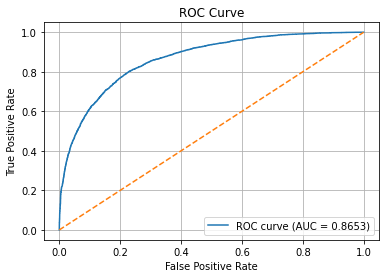

In [81]:
# Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr,_ = roc_curve(y_distant, y_pred_proba)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')            
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### PR Curve

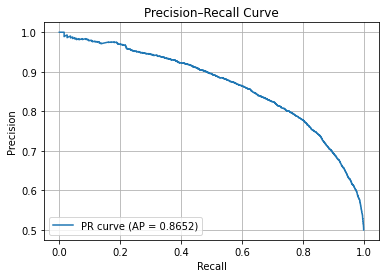

In [82]:
# # Compute precision, recall and thresholds
precision, recall, pr_thresholds = precision_recall_curve(y_distant, y_pred_proba)

# Compute average precision (area under PR curve)
avg_prec = average_precision_score(y_distant, y_pred_proba)

# Plot
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AP = {avg_prec:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## SHAP and LIME Plot (for distant stage lung cancer)

### SHAP Plot

 97%|=================== | 10854/11184 [00:43<00:01]       

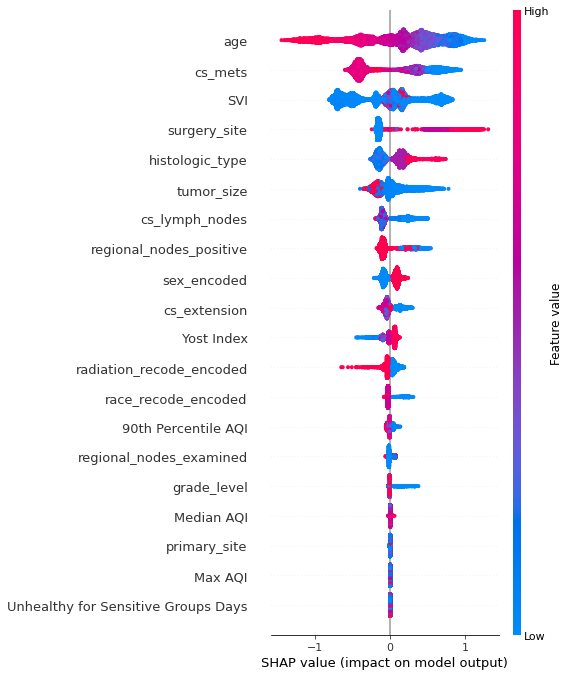

In [83]:
xgb_model.fit(X_distant, y_distant)
background = X_distant

# Create a TreeExplainer
explainer = shap.TreeExplainer(xgb_model, data=background)

# Compute SHAP values on the data you want to explain

shap_values = explainer.shap_values(X_distant)

# Produce the global summary‐beeswarm plot
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,               # SHAP values matrix
    X_distant,                # feature DataFrame (must line up)
    plot_type="dot",           # "dot" gives the beeswarm you showed
    color_bar_label="Feature value",
    show=False                 # we'll call plt.show() ourselves
)

plt.tight_layout()
plt.show()

### LIME Plot

Explaining sample #5839, true label = 1


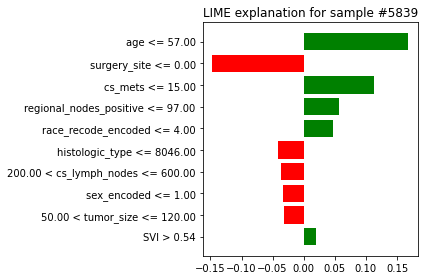

In [84]:
# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data   = X_distant.values,
    feature_names   = X_distant.columns.tolist(),
    class_names     = ['not survived','survived'],
    discretize_continuous = True,
    mode            = 'classification',
    random_state    = 42
)

# Pick a random instance each time you run:
i = np.random.randint(X_distant.shape[0])
print(f"Explaining sample #{i}, true label = {y_distant.iloc[i]}")

row = X_distant.iloc[i].values

# Generate the explanation
exp = explainer.explain_instance(
    data_row    = row,
    predict_fn  = xgb_model.predict_proba,   # LIME will call this under the hood
    num_features= 10                         # how many top features to show
)

# Display inline in a Jupyter notebook
exp.show_in_notebook(show_table=True)

# Or get a matplotlib figure
fig = exp.as_pyplot_figure()
plt.title(f'LIME explanation for sample #{i}')
plt.tight_layout()
plt.show()

## Paired t-Test

### Accuracy

In [ ]:
# Data: accuracy values (base, fair) per stage for lung cancer 
# Order: [Localized, Regional, Distant]

data = {
    'Lung': {'base': [0.8021, 0.7827, 0.7676], 'fair': [0.818, 0.7939, 0.7844]}
}

n_bootstraps = 10000

print("Cancer Type | Mean ΔAccuracy | 95% CI Lower | 95% CI Upper | Paired t-test p |")

for cancer, vals in data.items():
    base = np.array(vals['base'])
    fair = np.array(vals['fair'])
    delta = fair - base
    
    # Paired t-test
    t_stat, t_p = ttest_rel(fair, base)

    # Bootstrap CI for mean delta
    boot_means = []
    for _ in range(n_bootstraps):
        sample = resample(delta, replace=True, n_samples=len(delta))
        boot_means.append(np.mean(sample))
    ci_lower = np.percentile(boot_means, 2.5)
    ci_upper = np.percentile(boot_means, 97.5)
    
    print(f"{cancer:11} | {np.mean(delta):.4f}        | {ci_lower:.4f}       | {ci_upper:.4f}       | {t_p:.4f}          |")

Cancer Type | Mean ΔAccuracy | 95% CI Lower | 95% CI Upper | Paired t-test p |
Lung        | 0.0146        | 0.0112       | 0.0168       | 0.0138          |


### AUC

In [ ]:
# Data: AUC values (base, fair) per stage for lung cancer 
# Order: [Localized, Regional, Distant]

data = {
    'Lung':          {'base': [0.8846, 0.8626, 0.8468], 'fair': [0.8986, 0.8762, 0.8653]}  
}

n_bootstraps = 10000

print("Cancer Type | Mean ΔAUC | 95% CI Lower | 95% CI Upper | Paired t-test p |")

for cancer, vals in data.items():
    base = np.array(vals['base'])
    fair = np.array(vals['fair'])
    delta = fair - base
    
    # Paired t-test
    t_stat, t_p = ttest_rel(fair, base)

    # Bootstrap CI for mean delta
    boot_means = []
    for _ in range(n_bootstraps):
        sample = resample(delta, replace=True, n_samples=len(delta))
        boot_means.append(np.mean(sample))
    ci_lower = np.percentile(boot_means, 2.5)
    ci_upper = np.percentile(boot_means, 97.5)
    
    print(f"{cancer:11} | {np.mean(delta):.4f}   | {ci_lower:.4f}   | {ci_upper:.4f}   | {t_p:.4f}   |")


Cancer Type | Mean ΔAUC | 95% CI Lower | 95% CI Upper | Paired t-test p |
Lung        | 0.0154   | 0.0136   | 0.0185   | 0.0103   |


### XGB EOD Heatmap

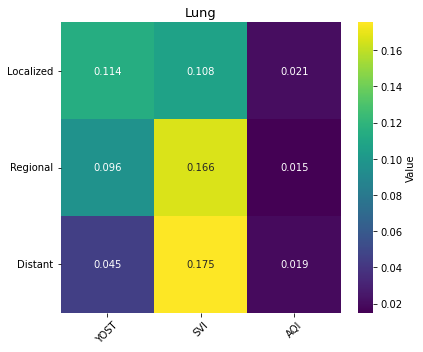

In [87]:
# Store your data in a dictionary: cancer name -> 3x3 array
data_dict = {
    "Lung": np.array([
        [0.1142, 0.1076, 0.0205],
        [0.0963, 0.1663, 0.0150],
        [0.0447, 0.1753, 0.0188]
    ]),
}

# Determine global color scale range
vmin = min(arr.min() for arr in data_dict.values())
vmax = max(arr.max() for arr in data_dict.values())

# Define tick labels
xticks = ["YOST", "SVI", "AQI"]
yticks = ["Localized", "Regional", "Distant"]

# --- Plot single heatmap ---
fig, ax = plt.subplots(figsize=(6, 5))

# Extract the only item from the dictionary
title, matrix = next(iter(data_dict.items()))

# Draw heatmap
sns.heatmap(matrix, annot=True, fmt=".3f", cmap="viridis",
            vmin=vmin, vmax=vmax,
            xticklabels=xticks, yticklabels=yticks,
            cbar_kws={'label': 'Value'}, ax=ax)

# Customize axes
ax.set_title(title, fontsize=13)
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()
